In [286]:
import pandas as pd
import numpy as np
import seaborn as sns
import random
random.seed(10)
from pandas_profiling import ProfileReport
from matplotlib import pyplot as plt
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,confusion_matrix
plt.rcParams["figure.figsize"] = (12,7)
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data/data_interview_test.csv',sep=":")

## Exploratory Data Analysis

In [12]:
df.shape

(12034, 14)

In [7]:
df.head(10)

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5,"10,000",10000,"10,468","10,006",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6,"10,000",10000,"10,468","10,008",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7,"10,000",10000,"10,468","10,009",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,"10,000",10000,"10,468","10,010",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,"10,000",10000,"10,468","10,011",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
df.describe()

,company_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
count,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000
mean,27247.797906,0.217901,0.031660,0.021522,0.986455,0.013877,0.024215,0.037893,0.753532,0.001005,0.076533
std,12024.542988,0.384535,0.122611,0.116995,0.115597,0.116987,0.128646,0.190945,0.430972,0.020134,0.265860
min,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,30000.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,50000.000000,1.000000,0.900000,0.800000,1.000000,1.000000,0.800000,1.000000,1.000000,0.600000,1.000000


In [8]:
df.dtypes

receipt_id                  object
company_id                   int64
matched_transaction_id      object
feature_transaction_id      object
DateMappingMatch           float64
AmountMappingMatch         float64
DescriptionMatch           float64
DifferentPredictedTime     float64
TimeMappingMatch           float64
PredictedNameMatch         float64
ShortNameMatch             float64
DifferentPredictedDate     float64
PredictedAmountMatch       float64
PredictedTimeCloseMatch    float64
dtype: object

In [10]:
df.isna().sum()

receipt_id                 0
company_id                 0
matched_transaction_id     0
feature_transaction_id     0
DateMappingMatch           0
AmountMappingMatch         0
DescriptionMatch           0
DifferentPredictedTime     0
TimeMappingMatch           0
PredictedNameMatch         0
ShortNameMatch             0
DifferentPredictedDate     0
PredictedAmountMatch       0
PredictedTimeCloseMatch    0
dtype: int64

In [6]:
prof = ProfileReport(df)
prof.to_file(output_file='EDA.html')

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

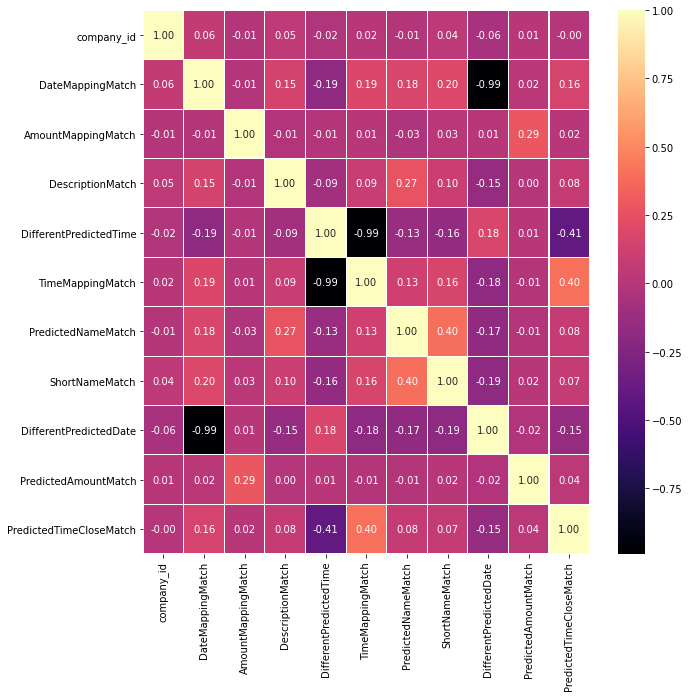

In [11]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=0.05, fmt= '.2f',cmap="magma")
plt.show()

In [14]:
feature_columns = ['DateMappingMatch', 'AmountMappingMatch','DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch',
                   'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate','PredictedAmountMatch', 'PredictedTimeCloseMatch']

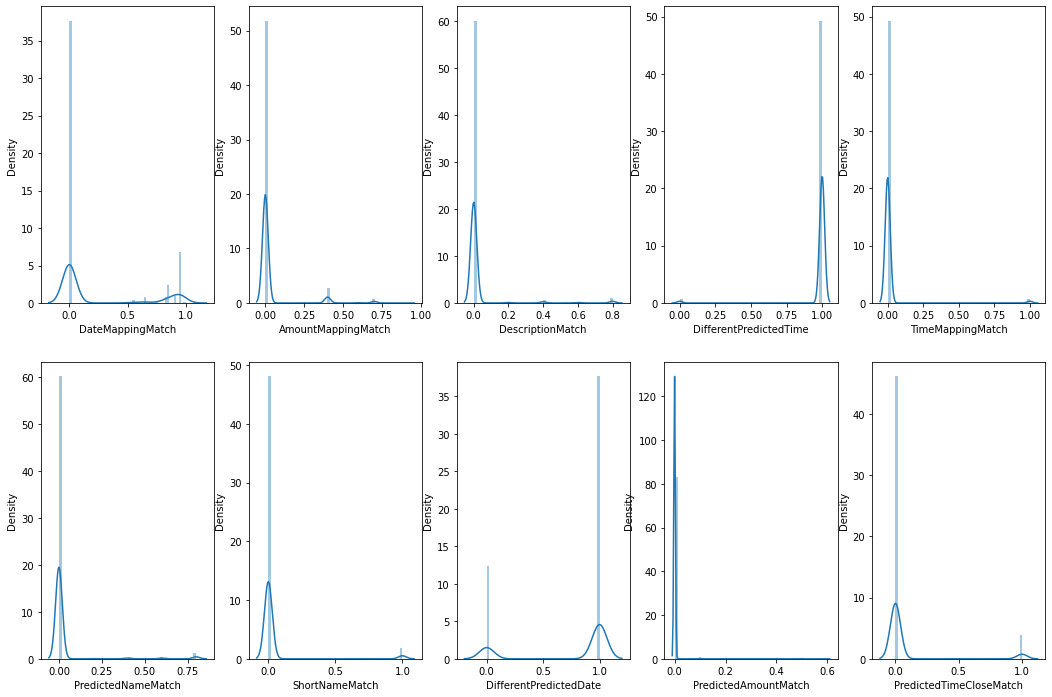

In [16]:
fig, axes = plt.subplots(2, 5,figsize=(18,12))

# unpack all the axes subplots
axe = axes.ravel()

# assign the plot to each subplot in axe
for i, c in enumerate(feature_columns):
    sns.distplot(df[c],ax=axe[i])
    
plt.show()

###  Insights

From the primary EDA , we can understand the following from the data

- Data contains 12034 rows with 1155 distinct receipts
- There are 4 Identifier columns and 10 feature columns in the data
- These are transactions from 5 different companies
- All the feature columns are either binary or float value ranging between 0,1
- The feature columns are values obtained by similarity matching at different levels of a transaction against an     original transaction
- There exists high negative correlation between these columns
    - DateMappingMatch --> DifferentPredictedDate
    - TimeMappingMatch --> DifferentPredictedTime

## Data Preparation

In [18]:
df.replace(',','', regex=True, inplace=True)

In [19]:
df[df['matched_transaction_id']=="10112"]

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
264,10021,10000,10112,10108,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
265,10021,10000,10112,10109,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
266,10021,10000,10112,10110,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
267,10021,10000,10112,10112,0.95,0.0,0.0,1.0,0.0,0.6,0.0,0.0,0.0,0.0
268,10021,10000,10112,10113,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
269,10021,10000,10112,10114,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Here we have an example of one receipt where the real transaction id is "10112" in matched_transaction_id columns
and all the transactions which got matched against it are in feature_transaction_id column. 

Here row 267 is the Correct match for transaction 10112 since matched_transaction_id and feature_transaction_id is
same [as per problem statement]

So using this idea , we can create a Target column which gives us idea about which transactions are the original matching transaction for a matched_transaction_id

In [20]:
df['CorrectMatch'] = np.where(df['matched_transaction_id']==df['feature_transaction_id'],1,0)

In [51]:
print(df['CorrectMatch'].value_counts())

0    11177
1      857
Name: CorrectMatch, dtype: int64


Out of 1155 transaction , we know the original transaction for 857 of them

We can make a subset out of our existing dataframe to get the transactions which have an original transaction in the given scenario which gets some noisy data out

In [24]:
ids_with_original_transactions = df[df['CorrectMatch']==1].matched_transaction_id.to_list()

match_trans_df = df[df['matched_transaction_id'].isin(ids_with_original_transactions)]

In [27]:
match_trans_df.shape

(6468, 15)

In [34]:
6468/857

7.5472578763127185

- We have 6468 transactions corresponding to 857 original transactions
- On Average we have around 7 transactions per one original transaction

We can also observe that for some transactions sets with Correct Match , the feature columns are same for both Correct as well as incorrect match

eg:-


In [35]:
match_trans_df[match_trans_df['matched_transaction_id']=="10113"]

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,CorrectMatch
1427,10133,10000,10113,10108,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1428,10133,10000,10113,10109,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1429,10133,10000,10113,10110,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1430,10133,10000,10113,10112,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1431,10133,10000,10113,10113,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1432,10133,10000,10113,10114,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Here you can see row number feature_transaction_id 10113  is the original matched transaction , 

If we check all the 10 feature columns of this transaction , we can see that 

The feature_transaction_ids 10112 & 10114 has exact same similarity feature matrix as 10113 which means that whatever technique we use , those three transactions will have the same score/features

Which essentially tells us that Both Incorrect and Correct Transaction has same feature vector within a matched_transaction_id

We don't have to filter them out because from the business context , what we are trying to acheive is to give the best matching transactions on top . So even if the similarity vectors are same for both Correct & Incorrect transactions , we just need to make sure that those transactions are the ones which comes on top which will defenitely include the Correct transaction

In [36]:
transactions_unique = match_trans_df.groupby(['matched_transaction_id']+feature_columns).agg({'CorrectMatch':'unique'}).reset_index()
transactions_unique['Count'] = transactions_unique['CorrectMatch'].apply(lambda x : len(x))

In [37]:
duplicated_transaction = transactions_unique[transactions_unique['Count']>1]['matched_transaction_id'].to_list()

In [42]:
len(duplicated_transaction)

262

We have 262 such cases where Both Correct and Incorrect matches for a transaction is has same feature vector

### Feature Selection

Primarily I'll go through some Data Visualizations and will try to deduce feature columns from them using the Labells which we have created

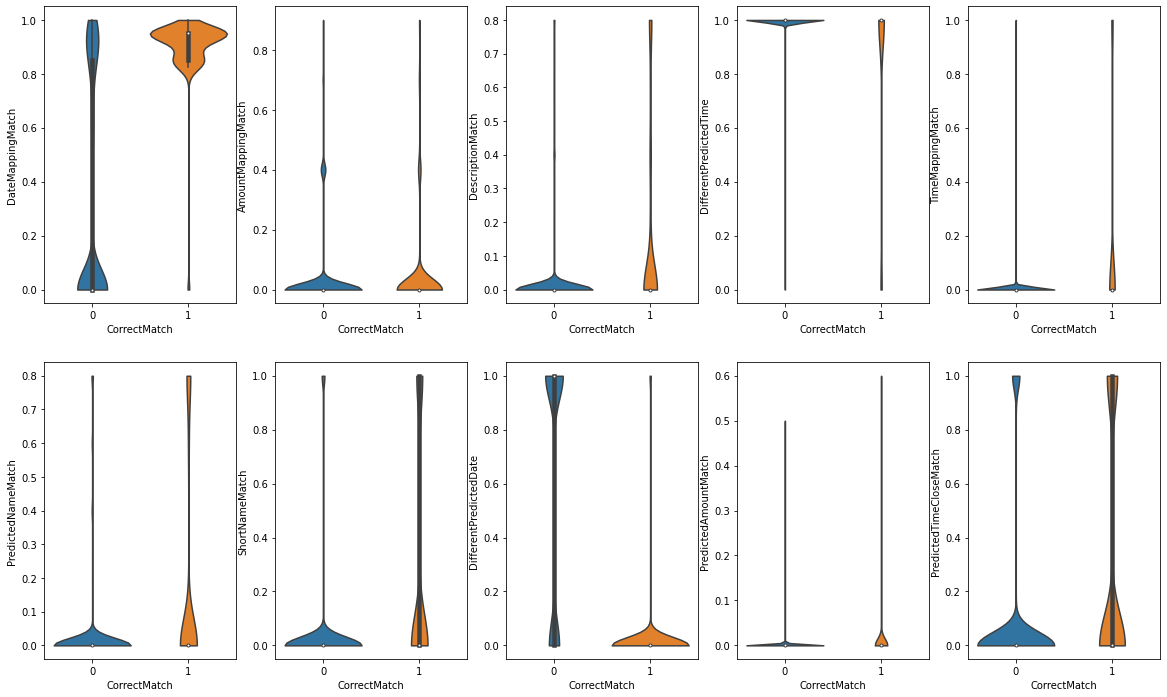

In [315]:
fig, axes = plt.subplots(2, 5,figsize=(20,12))

# unpack all the axes subplots
axe = axes.ravel()

# assign the plot to each subplot in axe
for i, c in enumerate(feature_columns):
    sns.violinplot(x="CorrectMatch", y=c,  data=match_trans_df, cut = 0,ax=axe[i])
    
plt.show()

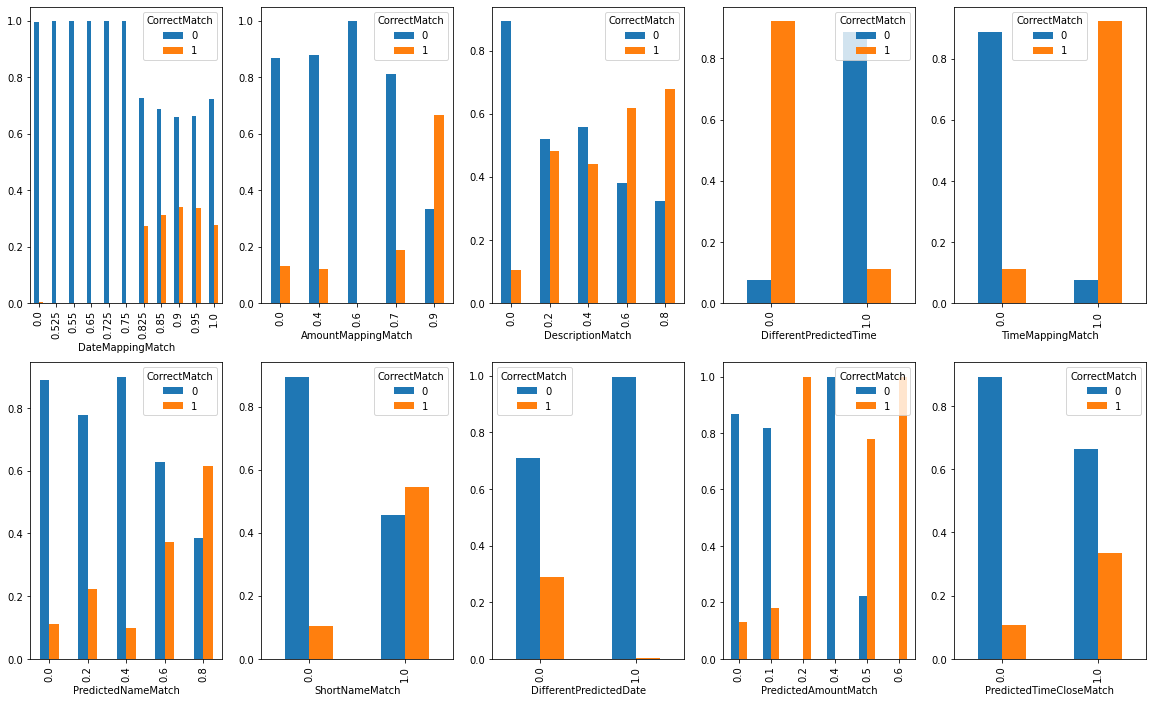

In [316]:
fig, axes = plt.subplots(2, 5,figsize=(20,12))

# unpack all the axes subplots
axe = axes.ravel()

# assign the plot to each subplot in axe
for i, c in enumerate(feature_columns):
    pd.crosstab(match_trans_df[c],match_trans_df['CorrectMatch'], normalize='index').plot(kind='bar',ax=axe[i])
    
plt.show()

From the plot and values , we can see which features are having 
- positive impact ( Value increases --> Higher chance of being Correct Match)
    - DateMappingMatch - Medium Positive impact
    - AmountMappingMatch - High positive impact
    - DescriptionMatch - High positive impact
    - TimeMappingMatch - High positive impact
    - PredictedNameMatch - High positive impact
    - ShortNameMatch - Weak/Medium positive impact
    - PredictedAmountMatch - High positive impact
    - PredictedTimeCloseMatch - Weak positive impact
    
- negative impact( Value Increases --> Higher chance of being an Incorrect Match)
    - DifferentPredictedDate - High negatie impact
    - DifferentPredictedTime - High negative impact

In [49]:
for col in feature_columns:
    print(pd.crosstab(match_trans_df[col],match_trans_df['CorrectMatch'],normalize='index'))

CorrectMatch             0         1
DateMappingMatch                    
0.000             0.996628  0.003372
0.525             1.000000  0.000000
0.550             1.000000  0.000000
0.650             1.000000  0.000000
0.725             1.000000  0.000000
0.750             1.000000  0.000000
0.825             0.726744  0.273256
0.850             0.686833  0.313167
0.900             0.660377  0.339623
0.950             0.663761  0.336239
1.000             0.722222  0.277778
CorrectMatch               0         1
AmountMappingMatch                    
0.0                 0.867718  0.132282
0.4                 0.880000  0.120000
0.6                 1.000000  0.000000
0.7                 0.812500  0.187500
0.9                 0.333333  0.666667
CorrectMatch             0         1
DescriptionMatch                    
0.0               0.894434  0.105566
0.2               0.518519  0.481481
0.4               0.558333  0.441667
0.6               0.380952  0.619048
0.8               0.3229

From the EDA , we know columns which have high correlation.

- DateMappingMatch --> DifferentPredictedDate:
    - Here we can see that DateMappingMatch column gives better predictive power since most the positive classes occur above 0.75 only and it being a continous variable can give better results when compared to a boolean value
- TimeMappingMatch --> DifferentPredictedTime:
    - There isn't much difference if we check their crosstabulation values , Still TimeMappingMatch seems to be a slightly better choice when compared to DifferentPredictedTime
    

## Model Building - Primary (Linear Sum)

Since the labels which we have are boolean and what we are trying to acheive is a likelihood score amount a set of transaction to be a correct transaction . 

My first thought of looking at is to create an Indexed score which can identify the Correct transaction inside a set of matched transactions and then use that to train a regression model

But first i need to make sure that the Indexed Score which i create can be a good indicator

I'll use the above identified feature importances to bin them into positive and negative groups and then try to find linear coefficients which gives the best results

In [232]:
high_pos = ['AmountMappingMatch','DescriptionMatch','TimeMappingMatch','PredictedNameMatch','PredictedAmountMatch','ShortNameMatch']
med_pos = ['DateMappingMatch']
low_pos = ['PredictedTimeCloseMatch']
high_neg = ['DifferentPredictedDate','DifferentPredictedTime']

Here , I'm not excluding highly correlated columns since the small changes which occurs among them can lead to improved efficiency . 

Since it is a linear sum , wouldn't be much of a problem there

In [237]:
match_trans_df['Similarity_Score'] = (1.5 * match_trans_df[high_pos].sum(axis=1)) + (0.8 * match_trans_df[med_pos].sum(axis=1)) + (0.01 * match_trans_df[low_pos].sum(axis=1)) - (1.3 * match_trans_df[high_neg].sum(axis=1))

In [238]:
match_trans_df['High_Similarity'] = match_trans_df.groupby('matched_transaction_id')['Similarity_Score'].transform('max')

In [239]:
match_trans_df['Predicted_Similarity'] = np.where(match_trans_df['Similarity_Score']==match_trans_df['High_Similarity'],1,0)

In [240]:
match_trans_df[match_trans_df['Predicted_Similarity']==1]['CorrectMatch'].value_counts()

1    784
0    664
Name: CorrectMatch, dtype: int64

Here we will be not looking at individual transaction per se . But we'll be looking at unique matched_transaction_id level.

Our goal is to find out the matching transaction among a subset of transaction rather than checking against all the transactions.

So analysis at a unique matched_transaction_id level makes better sense


So the metric which we'll be most concerned will be "What proportion of actual positives were identified correctly?"
aka *Recall* 

In [250]:
def find_metrics(y_test,y_pred):
    print(confusion_matrix(y_test,y_pred))
    print("Recall :{}".format(recall_score(y_test,y_pred)))

In [252]:
find_metrics(match_trans_df['CorrectMatch'],match_trans_df['Predicted_Similarity'])

[[4947  664]
 [  73  784]]
Recall :0.9148191365227538


I have used Weight of Evidence & Information Value for optimizing the weights for each of the feature in the feature list ,
but it seems to perform badly 

So i've gone with manual findings

In [253]:
match_trans_df['Score'] = match_trans_df['Similarity_Score'].apply(lambda x : (x - match_trans_df.Similarity_Score.min())/(match_trans_df.Similarity_Score.max() - match_trans_df.Similarity_Score.min()))

In [254]:
match_trans_df['Score']

20       0.068807
21       0.000000
22       0.000000
23       0.000000
24       0.000000
           ...   
12029    0.208716
12030    0.208716
12031    0.000000
12032    0.000000
12033    0.236239
Name: Score, Length: 6468, dtype: float64

Now we have an indexed score for our set . We can use this for building a ML Regressor model for predicting values

## ML Model Building - Secondary (Regressor)

While building model,  we'll remove the Correlated columns from our observation and non contributing(weak power of prediction) features as well

Since this is a regressor , we are not considering the Imbalanced balancing techniques like Oversampling,Undersampling

In [274]:
test_ = list(match_trans_df['matched_transaction_id'].unique())[:100]

In [275]:
match_trans_df.columns

Index(['receipt_id', 'company_id', 'matched_transaction_id',
       'feature_transaction_id', 'DateMappingMatch', 'AmountMappingMatch',
       'DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch',
       'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
       'PredictedAmountMatch', 'PredictedTimeCloseMatch', 'CorrectMatch',
       'Similarity_Score', 'High_Similarity', 'Predicted_Similarity', 'Score'],
      dtype='object')

In [276]:
f_cols = ['AmountMappingMatch','DescriptionMatch','TimeMappingMatch','PredictedNameMatch','PredictedAmountMatch','DateMappingMatch']

In [310]:
X_train = match_trans_df[~(match_trans_df['matched_transaction_id'].isin(test_))]
X_test  = match_trans_df[match_trans_df['matched_transaction_id'].isin(test_)]
X_val = X_test.copy()

In [282]:
X_train,y_train = X_train[f_cols],X_train['Score']
X_test,y_test = X_test[f_cols],X_test['Score']

In [287]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 120, num = 10)]

max_features = ['auto', 'sqrt']

max_depth = [int(x) for x in np.linspace(6, 25, num = 10)]
max_depth.append(None)

min_samples_split = [2, 5, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [288]:
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [6, 8, 10, 12, 14, 16, 18, 20, 22, 25, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 22, 34, 46, 58, 71, 83, 95, 107, 120]}


In [289]:
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   21.8s finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [6, 8, 10, 12, 14, 16, 18,
                                                      20, 22, 25, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 22, 34, 46, 58, 71,
                                                         83, 95, 107, 120]},
                   random_state=42, verbose=2)

In [290]:
rf_random.best_params_

{'n_estimators': 71,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 12,
 'bootstrap': True}

In [292]:
rf = RandomForestRegressor(n_estimators=71,min_samples_split=10,min_samples_leaf=1,max_features= 'sqrt',max_depth=12,bootstrap= True)

In [293]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=12, max_features='sqrt', min_samples_split=10,
                      n_estimators=71)

In [294]:
y_pred = rf.predict(X_test)

In [295]:
d = pd.DataFrame({'Actual':y_test,'Predicted':y_pred})

In [296]:
d

,Actual,Predicted
20,0.068807,0.080026
21,0.000000,0.003186
22,0.000000,0.003186
23,0.000000,0.003186
24,0.000000,0.003186
...,...,...
1422,0.000000,0.003186
1423,0.000000,0.003186
1424,0.000000,0.003186
1425,0.000000,0.003186


In [311]:
X_val['Predicted'] = y_pred

In [312]:
X_val['Sc'] = X_val.groupby('matched_transaction_id')['Predicted'].transform('max')

In [313]:
X_val['Pred_to_bin'] = np.where(X_val['Sc']==X_val['Predicted'],1,0)

In [314]:
find_metrics(X_val['CorrectMatch'],X_val['Pred_to_bin'])

[[639 148]
 [ 13  87]]
Recall :0.87


In The test set also , we were able to get 87 out of 100 Correct Transactions with similarity on top of the list